## Início

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [5]:
plt.style.use('ggplot')

In [6]:
pd.set_option("styler.format.thousands", ",")
pd.set_option("display.float_format", lambda x: '%.2f' % x)
%config InlineBackend.figure_format='retina'

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline
%xmode plain

Exception reporting mode: Plain


In [9]:
import session_info
session_info.show()

---

## Atributos

<img src="images/features.png" style="width: 50%;">

---

## Carregando os Dados

Agora com os dados *selecionados* e *otimizados*, façamos a EDA

In [10]:
from pathlib import Path
PATH_BENIGN = Path('pickles/df_benign.pkl')
PATH_ATTACK = Path('pickles/df_attack.pkl')

PosixPath('pickles/df_attack.pkl')

In [11]:
if PATH_BENIGN.is_file() and PATH_ATTACK.is_file():
    df_benign = pd.read_pickle(PATH_BENIGN)
    df_attack = pd.read_pickle(PATH_ATTACK)
    print(f"Arquivos carregados com sucesso")
else:
    print(f"Arquivos não encontrados em {PATH_ATTACK} e {PATH_BENIGN}")

Arquivos carregados com sucesso


## Números Correntemente

In [12]:
print(f"""
Ataque: {df_attack.shape[0]:,}
Normal: {df_benign.shape[0]:,}
""")


Ataque: 1,214,885
Normal: 1,098,191



---

## Tratando os Dados

### Atributos em `snake_case`

In [14]:
def to_snake_case(series):
    return series.lower().replace(" ", "_").replace("-", "_")

In [15]:
df_attack.columns = df_attack.columns.to_series().apply(to_snake_case)
df_attack['label'] = df_attack['label'].apply(to_snake_case)

In [16]:
print(df_benign.columns.values)

['header_length' 'protocol_type' 'time_to_live' 'rate' 'fin_flag_number'
 'syn_flag_number' 'rst_flag_number' 'psh_flag_number' 'ack_flag_number'
 'ece_flag_number' 'cwr_flag_number' 'ack_count' 'syn_count' 'fin_count'
 'rst_count' 'http' 'https' 'dns' 'telnet' 'smtp' 'ssh' 'irc' 'tcp' 'udp'
 'dhcp' 'arp' 'icmp' 'igmp' 'ipv' 'llc' 'tot_sum' 'min' 'max' 'avg' 'std'
 'tot_size' 'iat' 'number' 'variance' 'label']


Algumas `label`s requerem modificação manual

In [17]:
df_attack['label'].value_counts()

label
vulnerabilityscan       373351
mitm_arpspoofing        307560
dns_spoofing            178898
recon_hostdiscovery     134378
recon_osscan             98259
recon_portscan           82284
dictionarybruteforce     13064
browserhijacking          5859
commandinjection          5409
sqlinjection              5245
xss                       3846
backdoor_malware          3218
recon_pingsweep           2262
uploading_attack          1252
Name: count, dtype: int64

In [18]:
df_attack['label'] = df_attack['label'].replace({
    'dictionarybruteforce': 'dictionary_brute_force',
    'browserhijacking': 'browser_hijacking',
    'commandinjection': 'command_injection',
    'sqlinjection': 'sql_injection',
    'recon_pingsweep': 'recon_ping_sweep',
    'recon_hostdiscovery': 'recon_host_discovery',
    'recon_osscan': 'recon_os_scan',
    'recon_portscan': 'recon_port_scan',
    'vulnerabilityscan': 'vulnerability_scan',
    'mitm_arpspoofing': 'mitm_arp_spoofing'
})

In [19]:
df_attack['label'].value_counts()

label
vulnerability_scan        373351
mitm_arp_spoofing         307560
dns_spoofing              178898
recon_host_discovery      134378
recon_os_scan              98259
recon_port_scan            82284
dictionary_brute_force     13064
browser_hijacking           5859
command_injection           5409
sql_injection               5245
xss                         3846
backdoor_malware            3218
recon_ping_sweep            2262
uploading_attack            1252
Name: count, dtype: int64

### `Protocol Type` como nomes

> Fonte do `iana_map`: <https://www.kaggle.com/code/madhavmalhotra/creating-a-smaller-dataset-for-ciciot2023>

In [20]:
from utils.iana_protocols import iana_map
list(iana_map.items())[:5]  

[('0', 'HOPOPT'), ('1', 'ICMP'), ('2', 'IGMP'), ('3', 'GGP'), ('4', 'IPv4')]

In [21]:
def iana_convert(df):
    df["protocol_type"] = df["protocol_type"].apply(lambda num : iana_map[ str(int(num)) ]).astype('category')
    return df

In [25]:
benign_counts = df_benign['protocol_type'].value_counts().rename('Benign')
attack_counts = df_attack['protocol_type'].value_counts().rename('Attack')
combined_counts = pd.concat([benign_counts, attack_counts], axis=1).fillna("Nenhum")

,Benign,Attack
protocol_type,,
TCP,1004834.00,942452
UDP,90820.00,261464
HOPOPT,2302.00,10155
ICMP,235.00,811
IGMP,Nenhum,3


### Atributos ataque/normal iguais

In [26]:
assert list(df_attack.columns.values) == list(df_benign.columns.values)

Os nomes dos ataques também estão corretamente tratados

In [27]:
df_attack['label'].value_counts()

label
vulnerability_scan        373351
mitm_arp_spoofing         307560
dns_spoofing              178898
recon_host_discovery      134378
recon_os_scan              98259
recon_port_scan            82284
dictionary_brute_force     13064
browser_hijacking           5859
command_injection           5409
sql_injection               5245
xss                         3846
backdoor_malware            3218
recon_ping_sweep            2262
uploading_attack            1252
Name: count, dtype: int64

### Valores Nulos

In [28]:
missing_benign = df_benign.isnull().sum()
missing_attack = df_attack.isnull().sum()

print(missing_benign[missing_benign > 0])
print()
print(missing_attack[missing_attack > 0])

std         65
variance    65
dtype: int64

std         34
variance    34
dtype: int64


Como são poucos, vamos apenas eliminá-los

In [29]:
df_benign.dropna(inplace=True)
df_attack.dropna(inplace=True)

### Valores "Ruins" (`NaN`s e `Inf`s)

In [30]:
def clean_values(df, name):
    before = len(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    after = len(df)
    
    print(f"{name}: {before} -> {after} (delta {after - before})")
    return df

In [31]:
df_benign = clean_values(df_benign, "df_benign")
df_attack = clean_values(df_attack, "df_attack");

df_benign: 1098126 -> 1098126 (delta 0)
df_attack: 1214851 -> 1214848 (delta -3)


## Números Finais

Ao todo, foram retirados `65` observações normais, e `37` de ataque

In [32]:
print(f"""
Ataque: {df_attack.shape[0]:,}
Normal: {df_benign.shape[0]:,}
""")


Ataque: 1,214,848
Normal: 1,098,126



---

## Análise Exploratória

Aqui será preciso reverter os `float16`s em `float32`s, para que haja precisão suficiente para o cálculo das estatísticas

In [33]:
for df in (df_benign, df_attack):
    cols = df.select_dtypes(include=['float16']).columns
    df[cols] = df[cols].astype('float32')

### Medidas Descritivas

In [34]:
df_benign.describe()[:][1:]

,header_length,time_to_live,rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,...,llc,tot_sum,min,max,avg,std,tot_size,iat,number,variance
mean,27.26,114.98,2890.10,0.01,0.01,0.00,0.16,0.80,0.00,0.00,...,0.98,129.23,73.01,150.41,620.06,562.63,620.06,0.01,10.00,781731.87
std,6.39,51.21,28504.78,0.04,0.04,0.02,0.15,0.23,0.01,0.00,...,0.06,72.34,36.85,70.57,674.52,682.04,674.52,0.01,0.11,2264916.56
min,0.00,0.00,2.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,60.00,0.00,60.00,0.00,2.00,0.00
25%,24.00,73.88,86.10,0.00,0.00,0.00,0.00,0.70,0.00,0.00,...,1.00,63.00,60.00,83.00,100.50,56.31,100.50,0.00,10.00,3170.49
50%,29.59,98.81,172.06,0.00,0.00,0.00,0.10,0.90,0.00,0.00,...,1.00,134.00,66.00,146.00,247.75,404.27,247.75,0.01,10.00,163433.78
75%,32.00,147.62,604.44,0.00,0.00,0.00,0.30,1.00,0.00,0.00,...,1.00,192.00,66.00,226.00,1057.00,900.02,1057.00,0.01,10.00,810031.34
max,60.00,255.00,3145728.00,0.90,1.00,1.00,1.00,1.00,0.40,0.40,...,1.00,255.00,255.00,255.00,9432.00,11655.40,9432.00,0.35,10.00,135848458.00


In [35]:
df_attack.describe()[:][1:]

,header_length,time_to_live,rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,cwr_flag_number,...,llc,tot_sum,min,max,avg,std,tot_size,iat,number,variance
mean,23.39,95.67,18614.18,0.02,0.09,0.05,0.18,0.61,0.00,0.00,...,0.97,125.57,69.81,141.35,371.80,272.03,371.80,0.06,10.00,210799.99
std,9.10,43.43,81066.59,0.06,0.19,0.16,0.19,0.34,0.01,0.01,...,0.08,70.24,32.55,74.60,491.99,369.86,491.99,25.13,0.08,657271.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,46.00,0.00,46.00,0.00,2.00,0.00
25%,17.59,64.00,72.18,0.00,0.00,0.00,0.00,0.30,0.00,0.00,...,1.00,73.00,60.00,66.00,87.31,34.13,87.31,0.00,10.00,1165.15
50%,23.59,83.12,196.27,0.00,0.00,0.00,0.10,0.70,0.00,0.00,...,1.00,124.00,60.00,146.00,129.75,89.11,129.75,0.01,10.00,7941.05
75%,30.41,114.38,1093.38,0.00,0.10,0.00,0.30,1.00,0.00,0.00,...,1.00,182.00,66.00,220.00,460.00,451.87,460.00,0.02,10.00,204185.43
max,60.00,255.00,10485760.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,255.00,255.00,255.00,6208.00,10625.82,6208.00,24768.00,10.00,112907971.56


Esses `describe`s possuem 38 colunas pois ausentam-se 2: `protocol_type` e `label`

### Distribuição dos Ataques

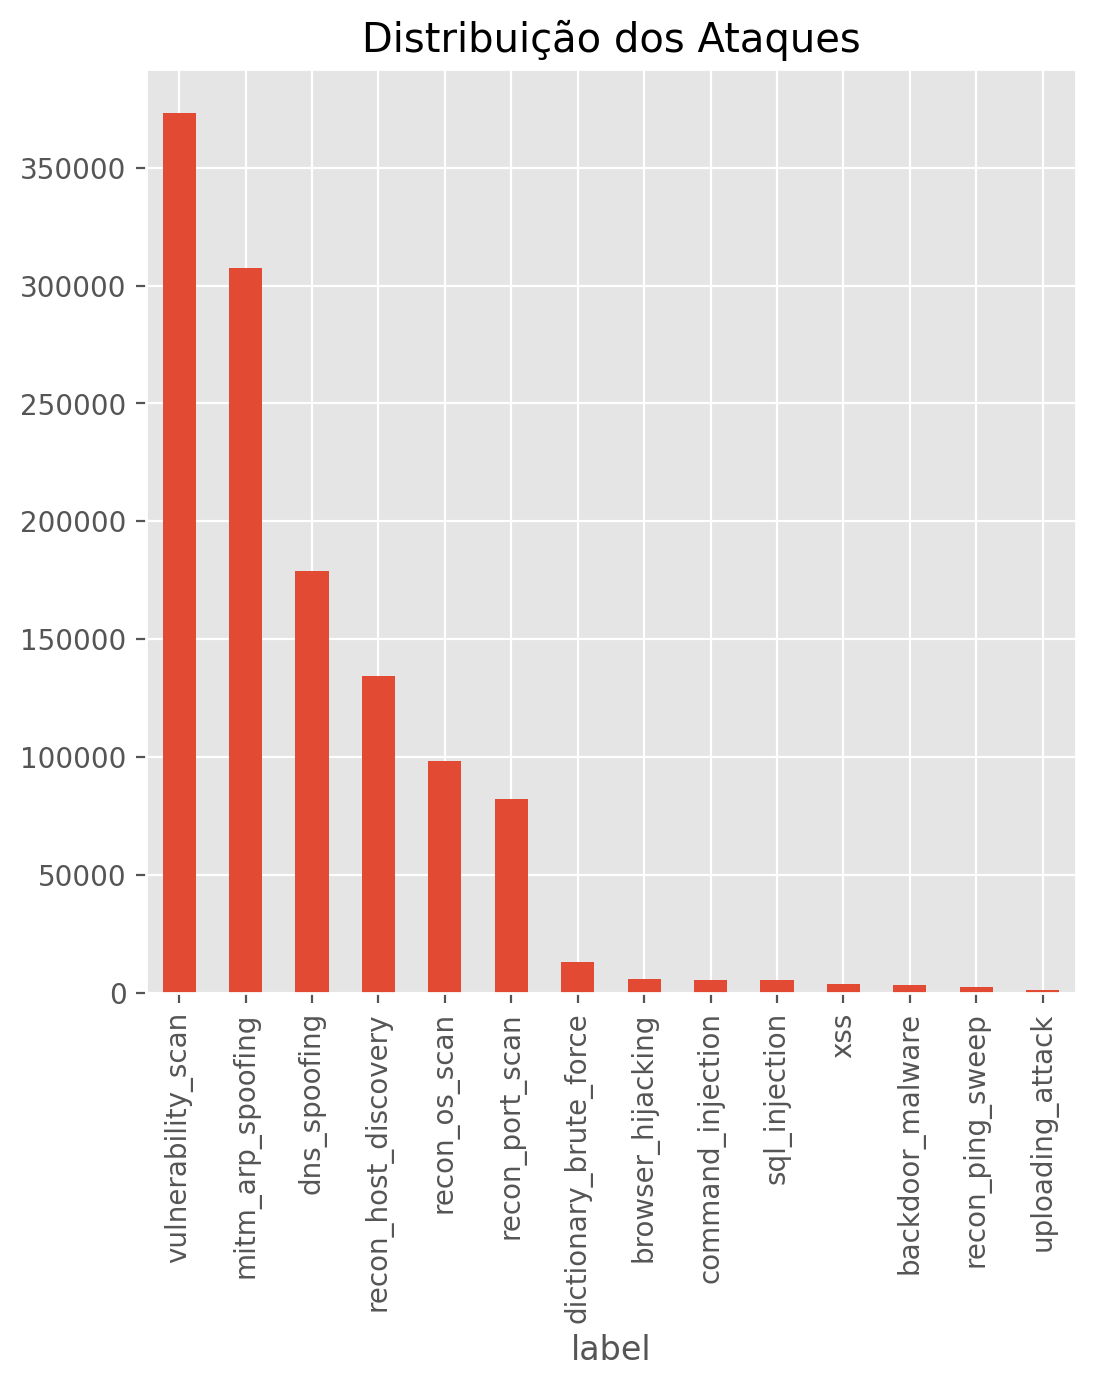

In [36]:
df_attack['label'].value_counts().plot(kind='bar', figsize=(6, 6))
plt.title('Distribuição dos Ataques')
plt.show()

### Boxplots

In [37]:
def plot_boxplots_side_by_side(df_benign, df_attack, n_cols=3):
    numeric_cols = df_benign.select_dtypes(exclude=['category']).columns
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        benign_series = df_benign[col]
        attack_series = df_attack[col]
        # DataFrame com 2 colunas: uma com valores, outra com a classe
        df_plot = pd.DataFrame({
            col: pd.concat([benign_series, attack_series]),
            'Group': ['Benign'] * len(benign_series) + ['Attack'] * len(attack_series)
        })
        sns.boxplot(x='Group', y=col, data=df_plot, ax=axes[i])
        axes[i].set_title(col)
    
    # Remove subplots vazios
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

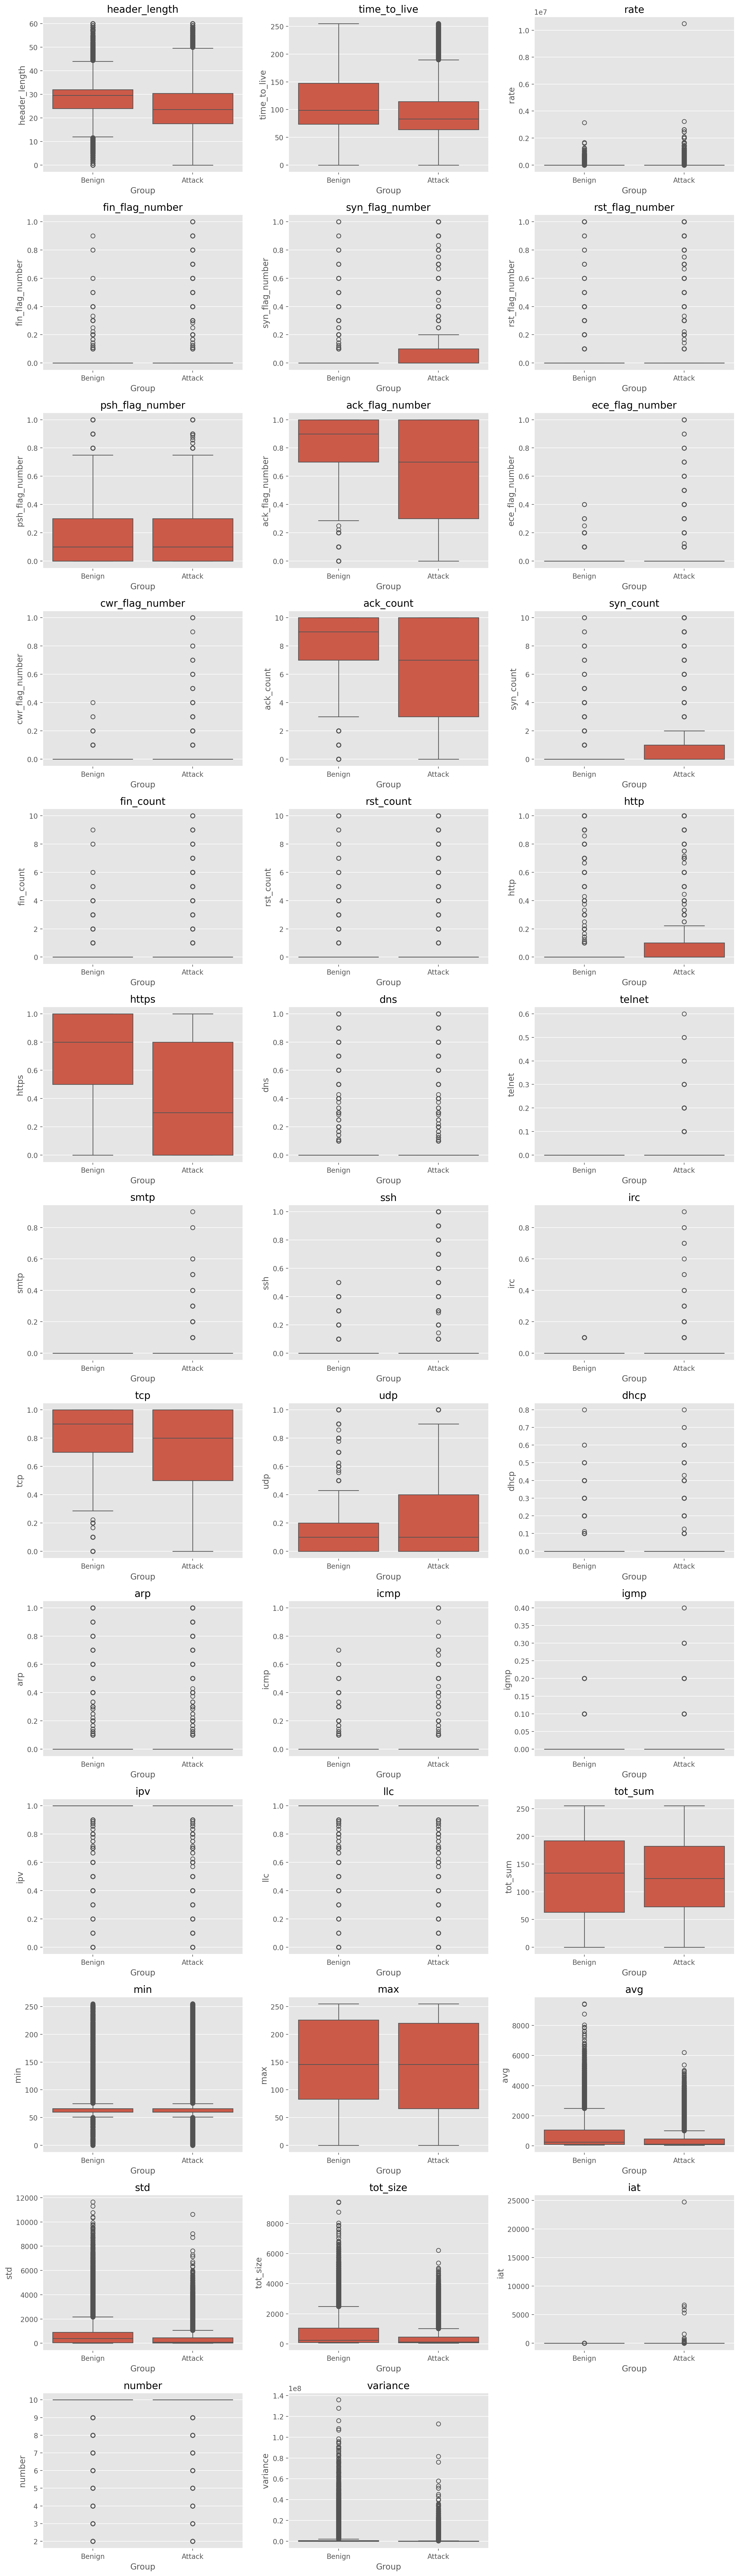

In [38]:
plot_boxplots_side_by_side(df_benign, df_attack)

Features que têm boxplots com diferenças visuais significativas:

- `ack_flag_number`
- `ack_count`
- `http`
- `https`

Features com distribuição muito desigual (boxplot somente com outliers):

- `rate`
- `fin_flag_number`, `rst_flag_number`, `ece_flag_number`, `cwr_flag_number`
- `fin_count`, `rst_count`
- `dns` ,`telnet` ,`smtp` ,`ssh` ,`irc` ,`dhcp` ,`arp` ,`icmp` ,`igmp` ,`ipv` ,`llc`
- `iat`
- `number`
- `variance`

### Correlação

Como temos muitos atributos, é melhor observar somente quem nos interessa, isto é, valores altos (`>= 0.7`)

In [40]:
def plot_pares_correlacao(df_benign, df_attack, limiar=0.8):
    df_benign_num = df_benign.select_dtypes(exclude=['category'])
    df_attack_num = df_attack.select_dtypes(exclude=['category'])
    
    corr_benign = df_benign_num.corr().abs()
    corr_attack = df_attack_num.corr().abs()
    
    def extrair_pares(corr):
        pares = [(corr.columns[i], corr.columns[j], corr.iloc[i, j])
                 for i in range(len(corr.columns)) for j in range(i) if corr.iloc[i, j] >= limiar]
        return sorted(pares, key=lambda x: x[2], reverse=True)
    
    pares_benign, pares_attack = extrair_pares(corr_benign), extrair_pares(corr_attack)

    perfect_benign = [p for p in pares_benign if np.isclose(p[2], 1.0)]
    perfect_attack = [p for p in pares_attack if np.isclose(p[2], 1.0)]
    
    # Pares diferente de 1
    pares_benign = [p for p in pares_benign if not np.isclose(p[2], 1.0)]
    pares_attack = [p for p in pares_attack if not np.isclose(p[2], 1.0)]

    # Printar os pares com correlação 1
    if perfect_benign or perfect_attack:
        print("\nPares com correlação próxima de 1:")
        for p in perfect_benign:
            print(f"[Benign] {p[0]} - {p[1]}")
        print()
        for p in perfect_attack:
            print(f"[Attack] {p[0]} - {p[1]}")
    print()

    fig, axes = plt.subplots(1, 2, figsize=(16, max(len(pares_benign), len(pares_attack)) * 0.25 + 2))

    def plot_correlacao(ax, pares, titulo, cor):
        if pares:
            nomes_pares = [f"{p[0]} - {p[1]}" for p in pares]
            valores_corr = [p[2] for p in pares]
            y_pos = np.arange(len(nomes_pares))
            
            ax.barh(y_pos, valores_corr, align='center', color=cor)
            ax.set_yticks(y_pos)
            ax.set_yticklabels(nomes_pares)
            ax.set_xlabel('Correlação Absoluta')
            ax.set_title(titulo)
            
            for i, v in enumerate(valores_corr):
                ax.text(v + 0.01, i, f'{v:.2f}', va='center')
        else:
            ax.text(0.5, 0.5, 'Nenhum par relevante encontrado', ha='center', va='center', transform=ax.transAxes)

    plot_correlacao(axes[0], pares_benign, f'Cor(Benignos) ≥ {limiar})', 'royalblue')
    plot_correlacao(axes[1], pares_attack, f'Cor(Ataques) ≥ {limiar})', 'orangered')

    plt.tight_layout()
    plt.show()


Pares com correlação próxima de 1:
[Benign] llc - ipv
[Benign] tot_size - avg
[Benign] ipv - arp
[Benign] llc - arp

[Attack] llc - ipv
[Attack] tot_size - avg
[Attack] ipv - arp
[Attack] llc - arp
[Attack] rst_count - rst_flag_number
[Attack] fin_count - fin_flag_number



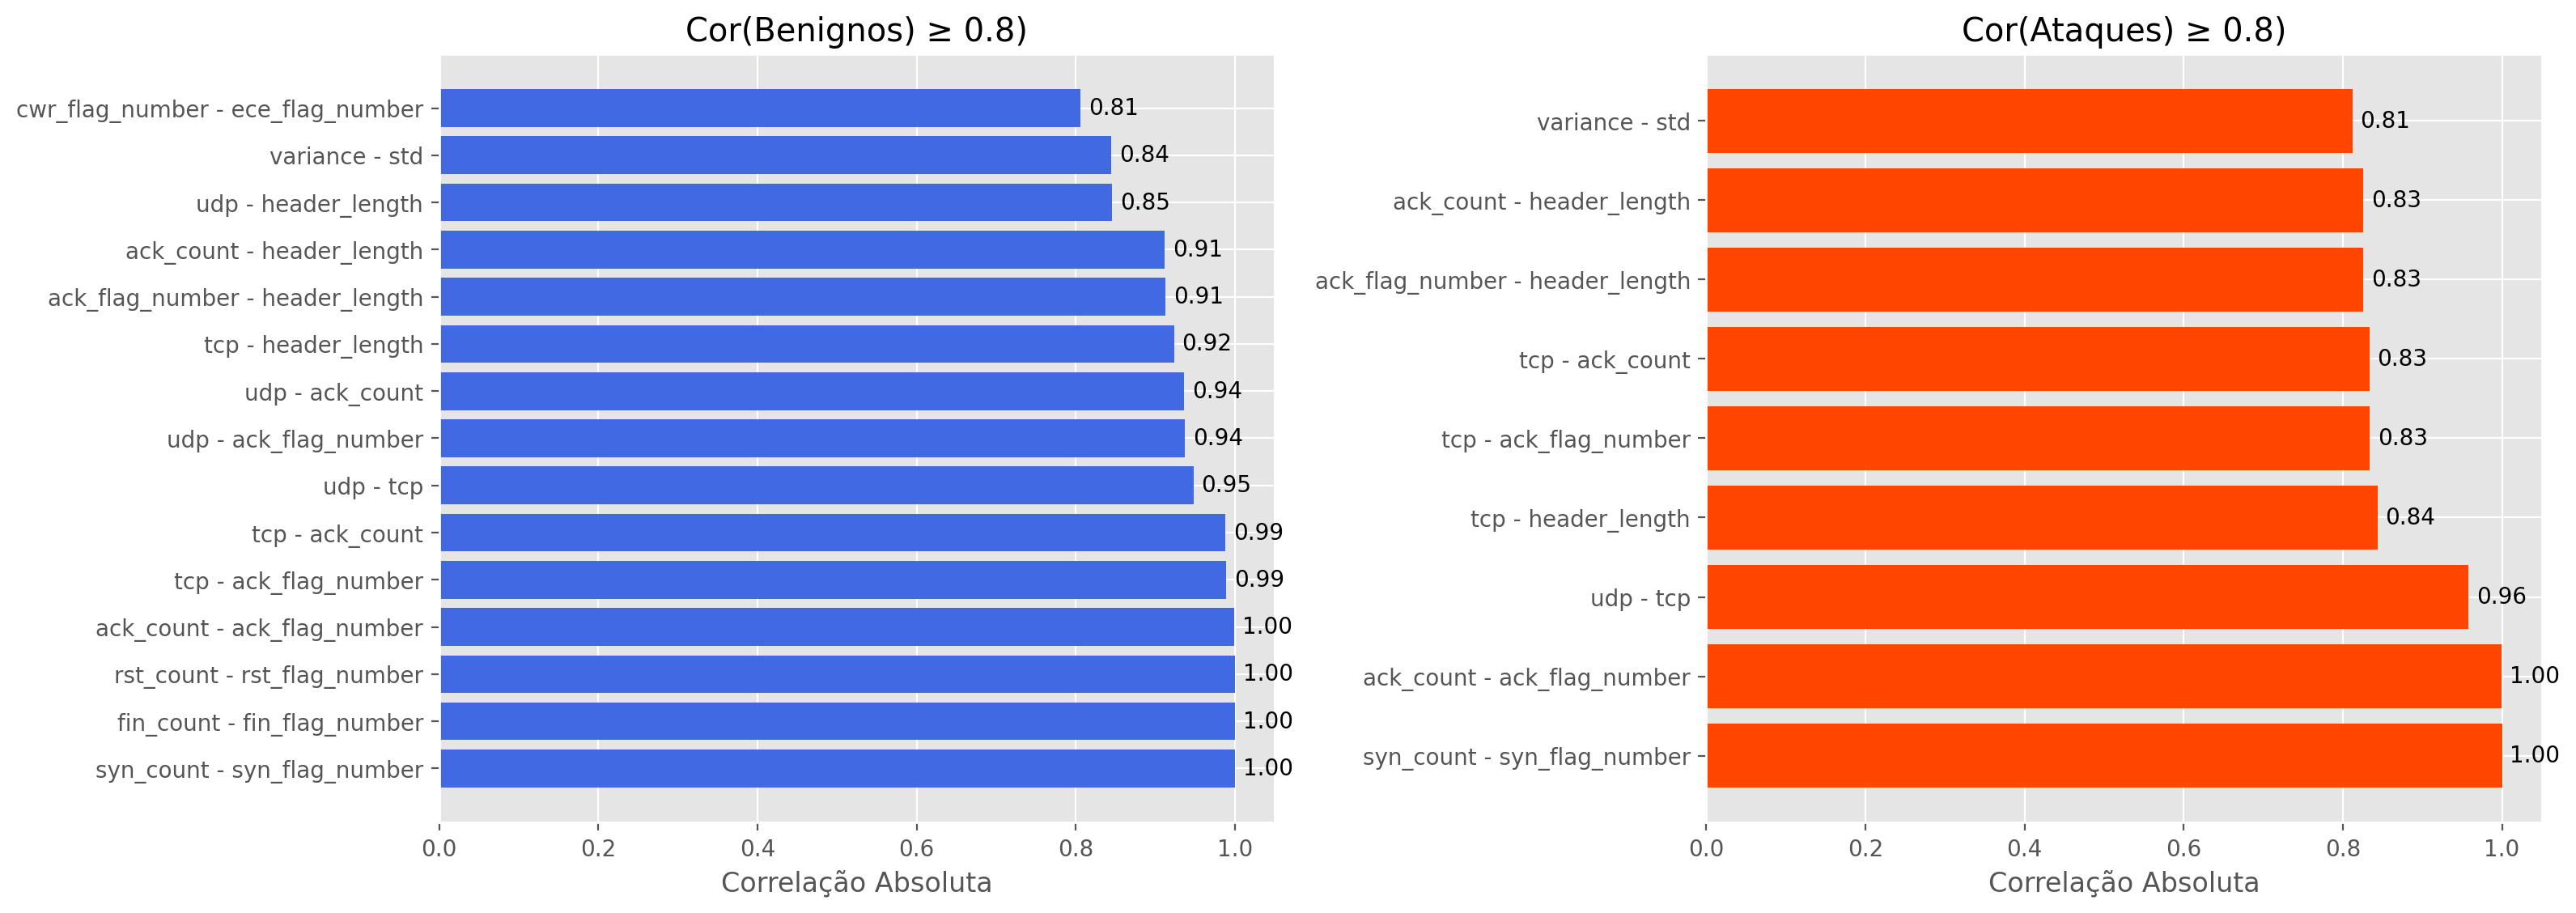

In [41]:
plot_pares_correlacao(df_benign, df_attack, limiar=0.8)

Muitos pares de atributos tem correlação alta, indicando uma possível melhora com *feature engineering*

### Histogramas

In [42]:
def plot_hist_intercalado(df_benign, df_attack, bins=50):
    num_features = df_benign.select_dtypes(exclude=['category']).shape[1]
    cols = 2
    rows = (num_features + cols - 1) // cols  # Garantir linhas suficientes
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 2))
    axes = axes.flatten()  # Facilita iteração
    
    for i, col in enumerate(df_benign.select_dtypes(exclude=['category']).columns):
        ax = axes[i]
        
        ax.hist(df_benign[col], bins=bins, color='royalblue', edgecolor='black', alpha=0.7, label='Benign')
        ax.hist(df_attack[col], bins=bins, color='orangered', edgecolor='black', alpha=0.7, label='Attack')

        ax.set_title(col)
        ax.legend()
    
    # Esconder subplots vazios (caso o número de features seja ímpar)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

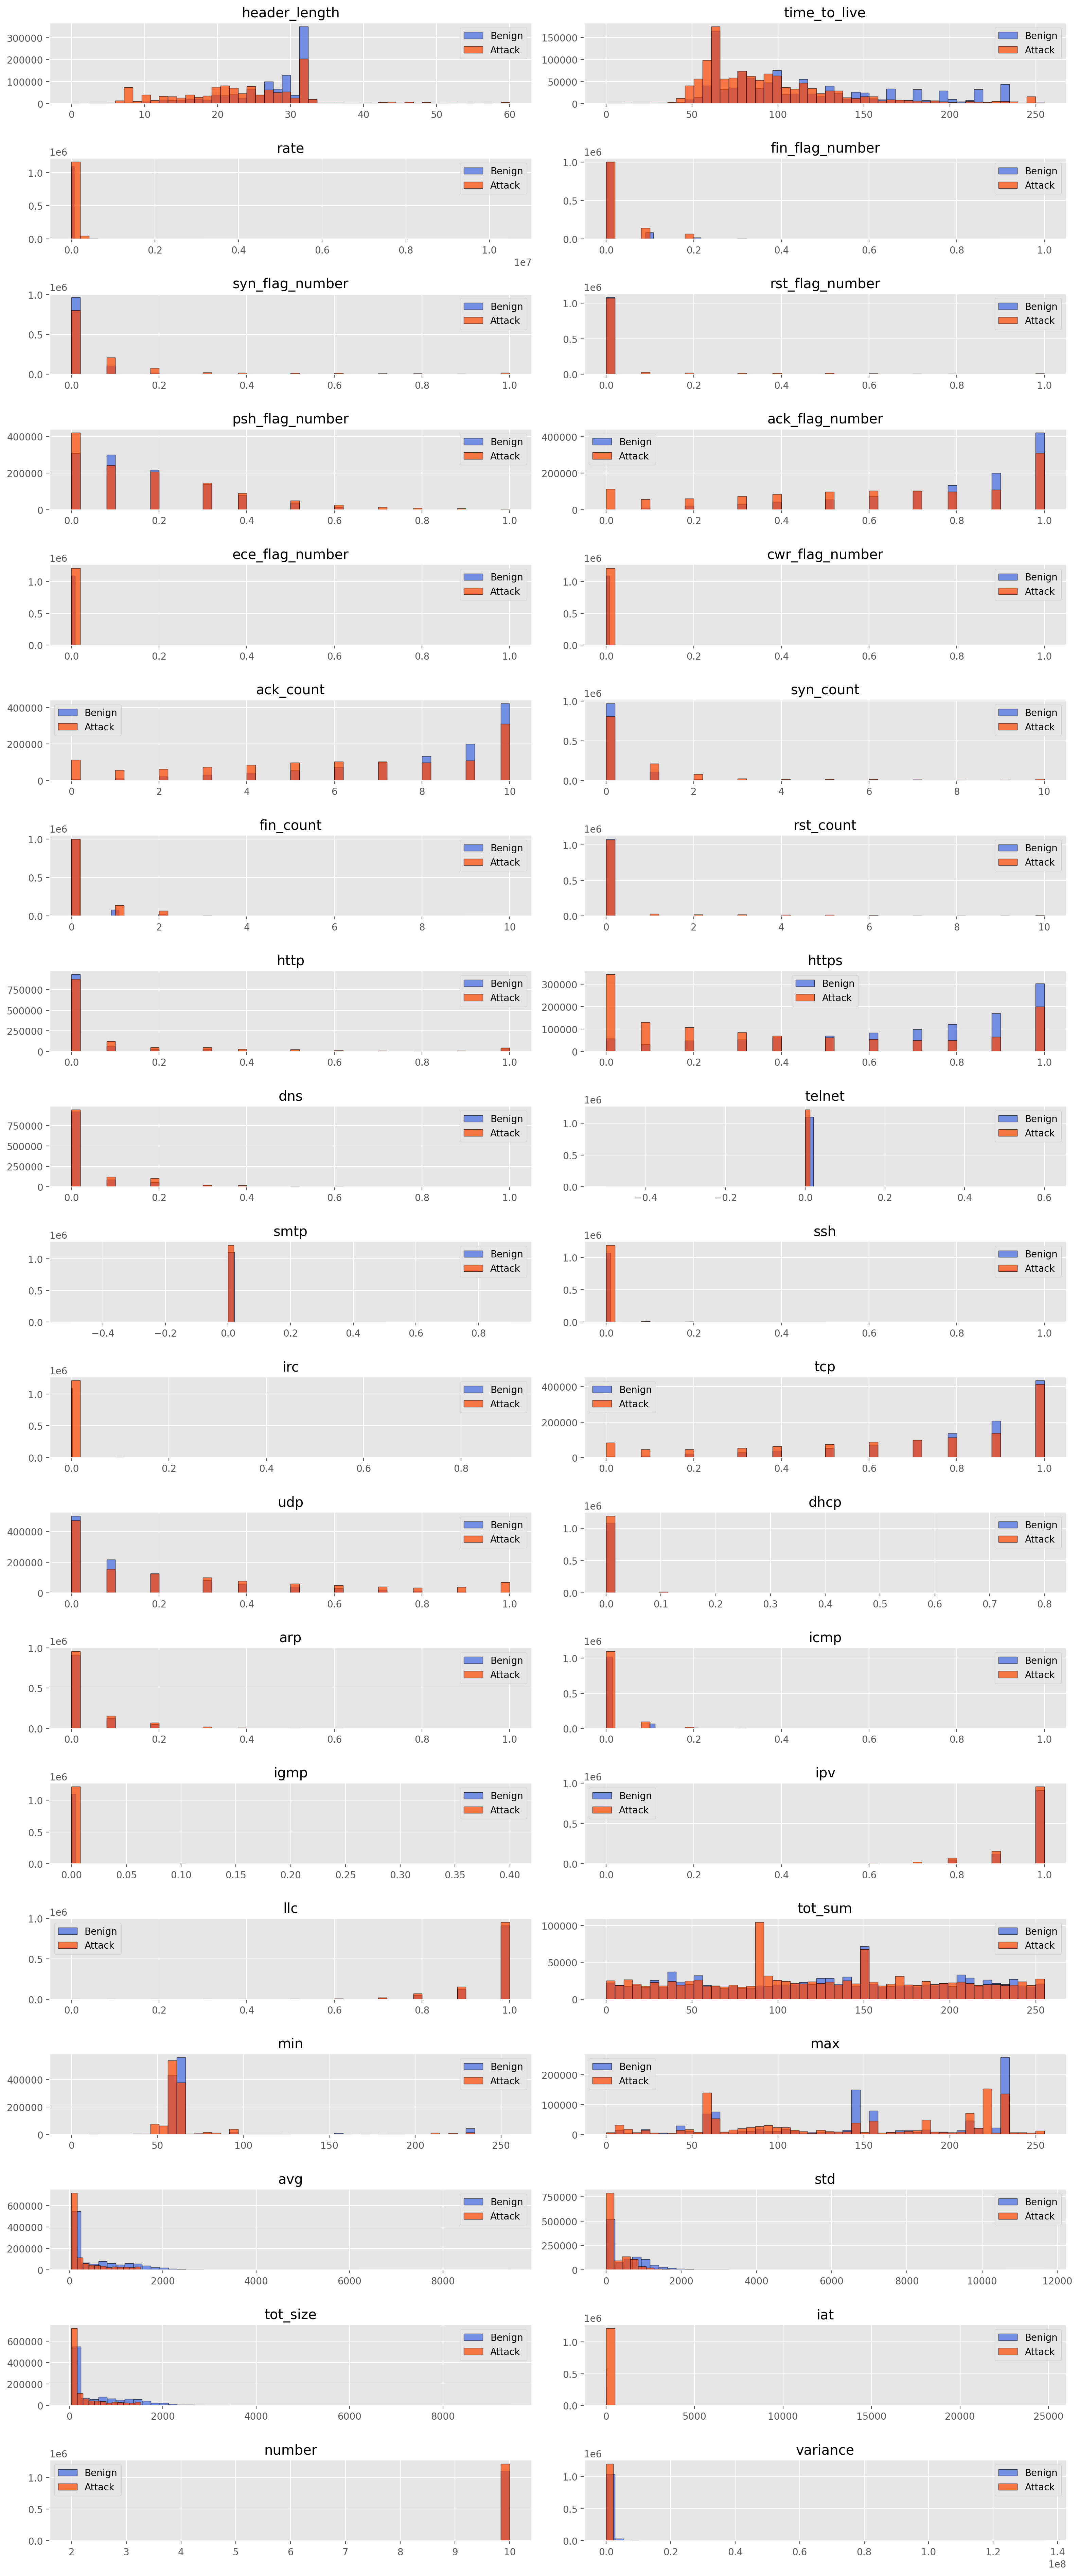

In [43]:
plot_hist_intercalado(df_benign, df_attack)

Histogramas Diferentes:

- `time_to_live`
- `https`
- `ack_count`

Ainda assim, a diferença não é muito (visualmente) significativa

### PCA

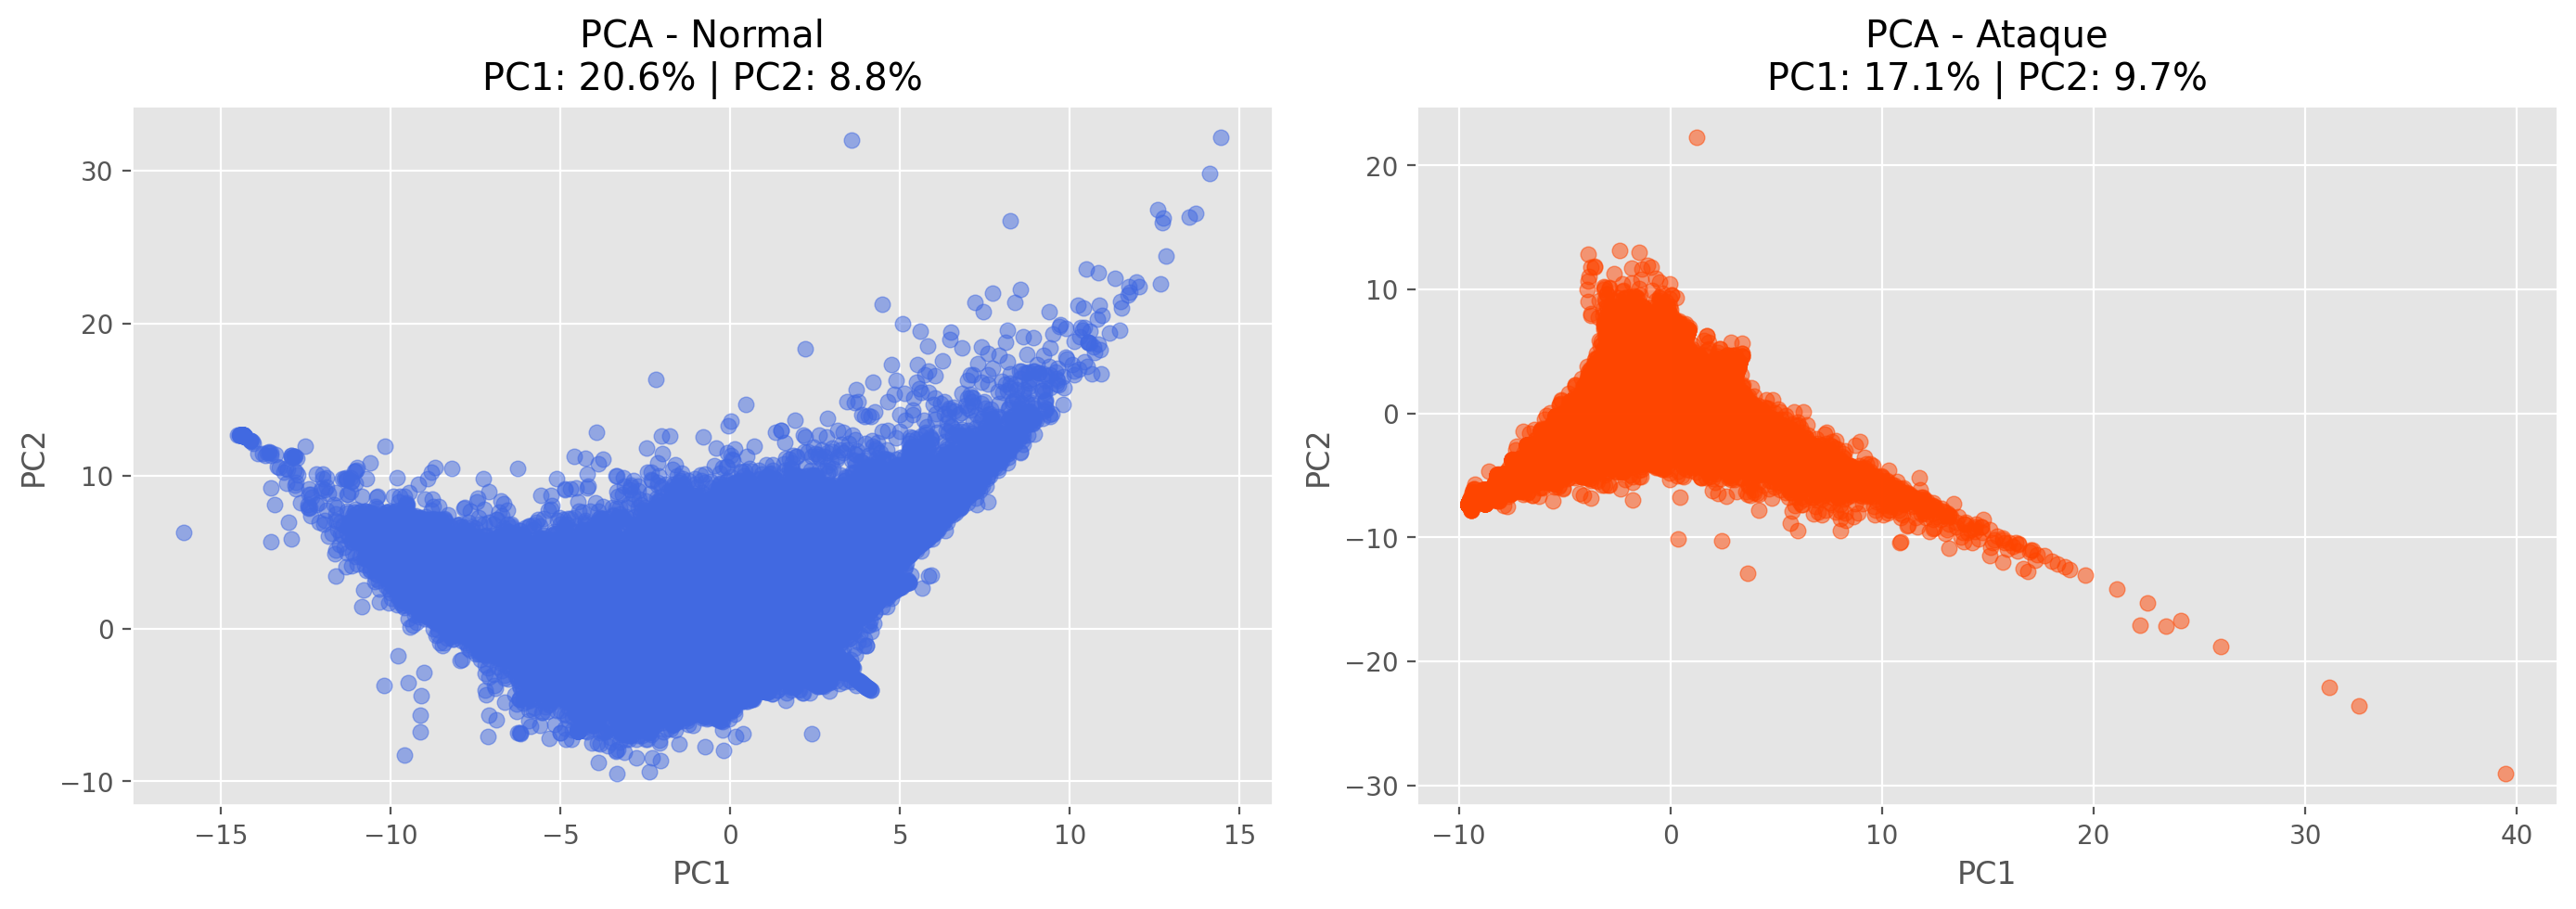

In [44]:
def plot_pca(df, ax, title, color):
    X = df.select_dtypes(exclude=['category']).values
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, color=color)
    ax.set_title(f"{title}\nPC1: {round(100*pca.explained_variance_ratio_[0],1)}% | PC2: {round(100*pca.explained_variance_ratio_[1],1)}%")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_pca(df_benign, axes[0], "PCA - Normal", "royalblue")
plot_pca(df_attack, axes[1], "PCA - Ataque", "orangered")

plt.tight_layout()
plt.show()

Algumas reflexões sobre os gráficos:

- A baixa variância explicada pelos primeiros dois componentes (menos de 30%) indica que os dados possuem **alta dimensionalidade** e podem precisar de **mais PCs para capturar a estrutura completa**

- Se quisermos **reduzir dimensionalidade**, apenas **duas PCs não são suficientes** para capturar a maior parte da variabilidade.

- As variáveis nos dados **normais** podem ter **relações não lineares**, e os de **ataque** parecem ter uma **estrutura mais direcionada**, com forte variação ao longo do primeiro componente principal.

- O gráfico de **ataque** tem um formato mais linear e alongado, sugerindo que **variáveis dominantes direcionando** os dados de ataque em um eixo específico.

- A diferença de padrões entre normal e ataque pode sugerir que **diferentes estratégias de feature engineering** podem ser úteis **para cada tipo de dado**.

- Pode ser interessante **testar técnicas não lineares** (como t-SNE ou UMAP) para verificar se a estrutura dos dados se preserva melhor nesses métodos.

---

## Agrupando Rótulos

Para reduzir a complexidade das análises posteriores, vamos agrupar os `recon`'s

In [45]:
import re
print([label for label in df_attack['label'].value_counts().index if re.search(r'recon', label)])

['recon_host_discovery', 'recon_os_scan', 'recon_port_scan', 'recon_ping_sweep']


Agrupando os `recon`'s, os rótulos serão fundidos para somente `recon`

In [46]:
df_attack['label'] = df_attack['label'].apply(lambda x: 'recon' if x.startswith('recon_') else x)
df_attack['label'] = df_attack['label'].astype('category')

In [47]:
df_attack['label'].value_counts()

label
vulnerability_scan        373344
recon                     317177
mitm_arp_spoofing         307542
dns_spoofing              178893
dictionary_brute_force     13064
browser_hijacking           5859
command_injection           5409
sql_injection               5244
xss                         3846
backdoor_malware            3218
uploading_attack            1252
Name: count, dtype: int64

Anteriormente eram `14` ataques. Com a aglutinação desses 4, temos agora `11` no total

---

## Juntando os datasets

In [48]:
df_combined = pd.concat([df_benign, df_attack], ignore_index=True)

,header_length,protocol_type,time_to_live,rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,tot_sum,min,max,avg,std,tot_size,iat,number,variance,label
0,29.59,TCP,114.12,68.74,0.00,0.00,0.00,0.10,0.90,0.00,...,0,66,234,947.00,706.04,947.00,0.01,10,498498.84,benign
1,24.80,TCP,149.12,47.63,0.00,0.00,0.00,0.20,0.70,0.00,...,181,66,89,146.12,114.67,146.12,0.02,10,13148.32,benign
2,17.59,TCP,156.12,35.46,0.00,0.00,0.00,0.30,0.60,0.00,...,163,60,234,323.50,434.41,323.50,0.03,10,188716.28,benign
3,24.80,TCP,91.12,68.69,0.00,0.00,0.00,0.10,0.70,0.00,...,192,66,58,1222.00,1347.20,1222.00,0.01,10,1814946.71,benign
4,24.00,TCP,180.88,97.07,0.00,0.00,0.00,0.00,0.70,0.00,...,60,66,134,134.00,135.29,134.00,0.01,10,18304.00,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312969,32.00,TCP,56.00,4262.50,0.00,0.00,0.00,0.40,1.00,0.00,...,4,234,58,3252.00,1142.20,3252.00,0.00,10,1304615.82,mitm_arp_spoofing
2312970,32.00,TCP,56.00,4752.75,0.00,0.00,0.00,0.40,1.00,0.00,...,12,234,58,2818.00,1068.43,2818.00,0.00,10,1141538.84,mitm_arp_spoofing
2312971,32.00,TCP,57.59,1165.76,0.00,0.00,0.00,0.40,1.00,0.00,...,20,66,58,2382.00,1556.55,2382.00,0.00,10,2422857.96,mitm_arp_spoofing
2312972,32.00,TCP,64.00,346636.69,0.00,0.00,0.00,0.00,1.00,0.00,...,148,66,66,66.00,0.00,66.00,0.00,10,0.00,mitm_arp_spoofing


Voltando `protocol_type` e `label` para `category`

In [49]:
df_combined['protocol_type'] = df_combined['protocol_type'].astype('category')
df_combined['label'] = df_combined['label'].astype('category')

In [50]:
df_combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312974 entries, 0 to 2312973
Data columns (total 40 columns):
 #   Column           Dtype   
---  ------           -----   
 0   header_length    float32 
 1   protocol_type    category
 2   time_to_live     float32 
 3   rate             float64 
 4   fin_flag_number  float32 
 5   syn_flag_number  float32 
 6   rst_flag_number  float32 
 7   psh_flag_number  float32 
 8   ack_flag_number  float32 
 9   ece_flag_number  float32 
 10  cwr_flag_number  float32 
 11  ack_count        uint8   
 12  syn_count        uint8   
 13  fin_count        uint8   
 14  rst_count        uint8   
 15  http             float32 
 16  https            float32 
 17  dns              float32 
 18  telnet           float32 
 19  smtp             float32 
 20  ssh              float32 
 21  irc              float32 
 22  tcp              float32 
 23  udp              float32 
 24  dhcp             float32 
 25  arp              float32 
 26  icmp          

---

## Salvando no disco

In [51]:
df_combined.to_pickle('pickles/df_combined.pkl')

---

## Próximos Passos

- Feature Engineering
    - Scaling
    - Py-FS
    - <https://www.kaggle.com/code/seneralkan/advanced-feature-engineering>
- Feature Selection
    - Variance Thresholding
    - Recursive Feature Elimination (RFE)
    - `featuretools`
    - <https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python>

---

## Conclusão

- Atributos e Ataques colocados em `snake_case`
- Poucos valores faltantes: foram eliminados
- NaNs e Inf's: também foram eliminados
- Ataques mais presentes: `vulnerability_scan`, `recon`, `mitm_arp_spoofing`
- Correlações: muitos pares têm valores muito altos, sugerindo possíveis agrupamentos
- Recon: os ataques de recon foram agrupados em `recon`
- Combinação: os datasets de tráfego benigno e de ataque foram combinados em um só
    - Total de `2,312,974` observações e `40` atributos

## Fim